---

### 🎓 **Professor**: Apostolos Filippas

### 📘 **Class**: AI Engineering

### 📋 **Homework 3**: Improving Lexical Search

### 📅 **Due Date**: Day of Lecture 4, 11:59 PM


**Note**: You are not allowed to share the contents of this notebook with anyone outside this class without written permission by the professor.

---

You'll apply what we covered in Lecture 3 (Lexical Search & BM25) to a real e-commerce search problem using the **WANDS dataset** 
- WANDS stands for Wayfair Annotated Dataset. It's a dataset of furniture products and search queries, along with human relevance judgments.

You will:
1. **Build a search engine** from scratch using BM25.
2. **Learn how to evaluate search results** using NDCG — a metric for measuring search quality
3. **Attempt to improve your search engine** by adding multiple fields
4. **Use LLMs to improve your search engine** by adding simple query understanding

Yes, *you* will do all these things. Let's go!

---

## Task 1: Environment Setup

First, let's set up your environment and verify everything works.

### 1a. Install dependencies and verify imports

Run `uv add pystemmer` in your terminal to add the Snowball stemmer. Then run the cell below to verify all imports work.

In [1]:
# Task 1a: Verify imports work
import pandas as pd
import numpy as np
from collections import Counter
import string
from pathlib import Path
# a stemmer from `pystemmer` for better tokenization
import Stemmer 
# llm packages
import litellm
from pydantic import BaseModel, Field
from typing import Optional
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Pandas display settings
# pd.set_option('display.max_colwidth', 100)

# Ignore pydantic warnings for litellm
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pydantic")

print("All imports successful!")

All imports successful!


### 1b. Verify API keys

Test that your API keys work by making a simple call.

In [2]:
# Task 1b: Verify API keys
response = litellm.completion(
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": "Say 'API working!' and nothing else."}],
    max_tokens=20
)
print(response.choices[0].message.content)

API working!


---

## Task 2: Load and Explore the WANDS Dataset

The **WANDS dataset** (Wayfair Annotated Dataset) contains:
- 43K furniture products from Wayfair
- 480 real search queries
- 233K human relevance judgments (query-product pairs)

This is a real-world search benchmark used to evaluate e-commerce search systems!

**Data Source**: [WANDS on GitHub](https://github.com/wayfair/WANDS)

The data files are pre-downloaded in the `data/` directory:
- `wayfair-products.csv` - Product catalog
- `wayfair-queries.csv` - Search queries
- `wayfair-labels.csv` - Relevance judgments

### Data Loading Functions (provided)

Run the cell below to define the loading functions.

In [3]:
# Data loading functions (provided)
# Note: Data from WANDS (Wayfair Annotated Dataset)
# Source: https://github.com/wayfair/WANDS

def load_wands_products(data_dir: str = "../data") -> pd.DataFrame:
    """
    Load WANDS products from local file.
    
    Args:
        data_dir: Path to the data directory containing wayfair-products.csv
        
    Returns:
        DataFrame with product information including product_id, product_name,
        product_class, category_hierarchy, product_description, etc.
    """
    filepath = Path(data_dir) / "wayfair-products.csv"
    products = pd.read_csv(filepath, sep='\t')
    products = products.rename(columns={'category hierarchy': 'category_hierarchy'})
    return products

def load_wands_queries(data_dir: str = "../data") -> pd.DataFrame:
    """
    Load WANDS queries from local file.
    
    Args:
        data_dir: Path to the data directory containing wayfair-queries.csv
        
    Returns:
        DataFrame with query_id and query columns
    """
    filepath = Path(data_dir) / "wayfair-queries.csv"
    queries = pd.read_csv(filepath, sep='\t')
    return queries

def load_wands_labels(data_dir: str = "../data") -> pd.DataFrame:
    """
    Load WANDS relevance labels from local file.
    
    Args:
        data_dir: Path to the data directory containing wayfair-labels.csv
        
    Returns:
        DataFrame with query_id, product_id, label (Exact/Partial/Irrelevant),
        and grade (2/1/0) columns
    """
    filepath = Path(data_dir) / "wayfair-labels.csv"
    labels = pd.read_csv(filepath, sep='\t')
    grade_map = {'Exact': 2, 'Partial': 1, 'Irrelevant': 0}
    labels['grade'] = labels['label'].map(grade_map)
    return labels

print("Loading functions defined!")

Loading functions defined!


### 2a. Load the data

Use the provided functions to load all three datasets. Print the number of rows in each.

In [4]:
# Task 2a: Load the data

# YOUR CODE HERE
df_product = load_wands_products()
df_query = load_wands_queries()
df_label = load_wands_labels()

print(f'Number of rows for the product dataframe: {df_product.shape[0]}')
print(f'Number of rows for the query dataframe: {df_query.shape[0]}')
print(f'Number of rows for the label dataframe: {df_label.shape[0]}')

Number of rows for the product dataframe: 42994
Number of rows for the query dataframe: 480
Number of rows for the label dataframe: 233448


### 2b. Explore products

List the available columns, and display a few sample products. 

Which columns might be useful for search?

In [5]:
# YOUR CODE HERE
print('Column names for the product dataframe are:\n')
for col in df_product.columns:
    print(col)

Column names for the product dataframe are:

product_id
product_name
product_class
category_hierarchy
product_description
product_features
rating_count
average_rating
review_count


In [6]:
# YOUR CODE HERE
print('The first five products:\n')
df_product.head()

The first five products:



,product_id,product_name,product_class,category_hierarchy,product_description,product_features,rating_count,average_rating,review_count
0,0,solid wood platform bed,Beds,Furniture / Bedroom Furniture / Beds & Headboa...,"good , deep sleep can be quite difficult to ha...",overallwidth-sidetoside:64.7|dsprimaryproducts...,15.0,4.5,15.0
1,1,all-clad 7 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances ...,"create delicious slow-cooked meals , from tend...",capacityquarts:7|producttype : slow cooker|pro...,100.0,2.0,98.0
2,2,all-clad electrics 6.5 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances ...,prepare home-cooked meals on any schedule with...,features : keep warm setting|capacityquarts:6....,208.0,3.0,181.0
3,3,all-clad all professional tools pizza cutter,"Slicers, Peelers And Graters",Browse By Brand / All-Clad,this original stainless tool was designed to c...,overallwidth-sidetoside:3.5|warrantylength : l...,69.0,4.5,42.0
4,4,baldwin prestige alcott passage knob with roun...,Door Knobs,Home Improvement / Doors & Door Hardware / Doo...,the hardware has a rich heritage of delivering...,compatibledoorthickness:1.375 '' |countryofori...,70.0,5.0,42.0


In [7]:
# YOUR CODE HERE
print(f'Based on the column names and sample products, these columns might be useful for searching products:\n')
print(df_product.columns[1])
print(df_product.columns[3])
print(df_product.columns[4])
print(df_product.columns[5])

Based on the column names and sample products, these columns might be useful for searching products:

product_name
category_hierarchy
product_description
product_features


### 2c. Understand relevance judgments

The `labels` dataset contains human judgments of relevance. In particular, for each query-product pair, it contains:
| Label        | Grade | Description                                 |
|--------------|-------|---------------------------------------------|
| Exact        |   2   | This product is exactly what the user wants |
| Partial      |   1   | This product is somewhat relevant           |
| Irrelevant   |   0   | This product doesn't match the query        |

First, let's look at the distribution of grades.

In [8]:
# Task 2c: Understand judgments

# YOUR CODE HERE
grade_type = set(df_label['grade'])
for type in grade_type:
    grade_count = len(df_label[df_label['grade'] == type])
    print(f'The number of grade {type} is {grade_count}.')

The number of grade 0 is 61201.
The number of grade 1 is 146633.
The number of grade 2 is 25614.


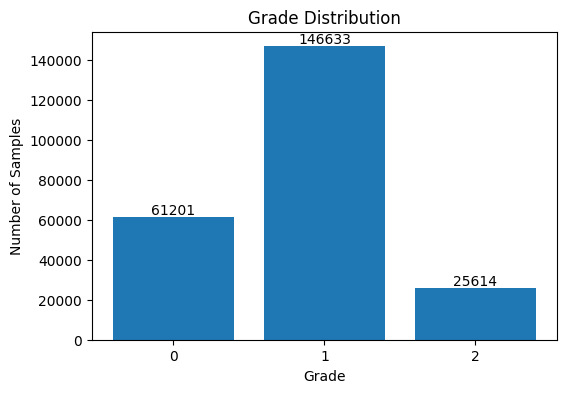

In [9]:
# YOUR CODE HERE
import matplotlib.pyplot as plt
grade_counts = df_label['grade'].value_counts().sort_index()

plt.figure(figsize = (6,4))
plt.bar(grade_counts.index.astype(str), grade_counts.values)
plt.title('Grade Distribution')
plt.xlabel('Grade')
plt.ylabel('Number of Samples')

for i, v in enumerate(grade_counts.values):
    plt.text(i, v, str(v), ha = 'center', va = 'bottom')

plt.show()

---
## Task 3: Build and Run BM25 Search

Now let's build a BM25 search engine! We'll use the same concepts from Lecture 3.

### Provided Functions

We're giving you these functions to work with. Run the next cell to define them, then look at the examples.

| Function | What it does |
|----------|--------------|
| `snowball_tokenize(text)` | Tokenizes text, removes punctuation, stems words |
| `build_index(docs, tokenizer)` | Builds an inverted index from a list of documents |
| `get_tf(term, doc_id, index)` | Gets term frequency for a term in a document |
| `get_df(term, index)` | Gets document frequency for a term (how many docs contain the term) |
| `bm25_idf(df, num_docs)` | Calculates the IDF component of BM25 |
| `bm25_tf(tf, doc_len, avg_doc_len)` | Calculates the TF normalization for BM25 |
| `score_bm25(query, index, ...)` | Scores all documents for a query using BM25 |
| `search_products(query, ...)` | Searches and returns top-k results |

In [10]:
# Provided functions - run this cell to define them

stemmer = Stemmer.Stemmer('english')
punct_trans = str.maketrans({key: ' ' for key in string.punctuation})

def snowball_tokenize(text: str) -> list[str]:
    """
    Tokenize text with Snowball stemming.
    
    Args:
        text: The text to tokenize
        
    Returns:
        List of stemmed tokens
    """
    if pd.isna(text) or text is None:
        return []
    text = str(text).translate(punct_trans)
    tokens = text.lower().split()
    return [stemmer.stemWord(token) for token in tokens]

def build_index(docs: list[str], tokenizer) -> tuple[dict, list[int]]:
    """
    Build an inverted index from a list of documents.
    
    Args:
        docs: List of document strings to index
        tokenizer: Function that takes text and returns list of tokens
        
    Returns:
        index: dict mapping term -> {doc_id: term_count}
        doc_lengths: list of document lengths (in tokens)
    """
    index = {}
    doc_lengths = []
    
    for doc_id, doc in enumerate(docs):
        tokens = tokenizer(doc)
        doc_lengths.append(len(tokens))
        term_counts = Counter(tokens)
        
        for term, count in term_counts.items():
            if term not in index:
                index[term] = {}
            index[term][doc_id] = count
    
    return index, doc_lengths

def get_tf(term: str, doc_id: int, index: dict) -> int:
    """
    Get term frequency for a term in a document.
    
    Args:
        term: The term to look up
        doc_id: The document ID
        index: The inverted index
        
    Returns:
        Term frequency (count), or 0 if not found
    """
    if term in index and doc_id in index[term]:
        return index[term][doc_id]
    return 0

def get_df(term: str, index: dict) -> int:
    """
    Get document frequency for a term.
    
    Args:
        term: The term to look up
        index: The inverted index
        
    Returns:
        Number of documents containing the term
    """
    if term in index:
        return len(index[term])
    return 0

def bm25_idf(df: int, num_docs: int) -> float:
    """
    BM25 IDF formula.
    
    Args:
        df: Document frequency
        num_docs: Total number of documents
        
    Returns:
        IDF score
    """
    return np.log((num_docs - df + 0.5) / (df + 0.5) + 1)

def bm25_tf(tf: int, doc_len: int, avg_doc_len: float, k1: float = 1.2, b: float = 0.75) -> float:
    """
    BM25 TF normalization.
    
    Args:
        tf: Term frequency
        doc_len: Document length in tokens
        avg_doc_len: Average document length
        k1: Saturation parameter (default 1.2)
        b: Length normalization (default 0.75)
        
    Returns:
        Normalized TF score
    """
    return (tf * (k1 + 1)) / (tf + k1 * (1 - b + b * doc_len / avg_doc_len))

def score_bm25(query: str, index: dict, num_docs: int, doc_lengths: list[int], 
               tokenizer, k1: float = 1.2, b: float = 0.75) -> np.ndarray:
    """
    Score all documents using BM25.
    
    Args:
        query: The search query
        index: Inverted index
        num_docs: Total number of documents
        doc_lengths: List of document lengths
        tokenizer: Tokenization function
        
    Returns:
        Array of scores for each document
    """
    query_tokens = tokenizer(query)
    scores = np.zeros(num_docs)
    avg_doc_len = np.mean(doc_lengths) if doc_lengths else 1.0
    
    for token in query_tokens:
        df = get_df(token, index)
        if df == 0:
            continue
        
        idf = bm25_idf(df, num_docs)
        
        if token in index:
            for doc_id, tf in index[token].items():
                tf_norm = bm25_tf(tf, doc_lengths[doc_id], avg_doc_len, k1, b)
                scores[doc_id] += idf * tf_norm
    
    return scores

def search_products(query: str, products_df: pd.DataFrame, index: dict, 
                    doc_lengths: list[int], tokenizer, k: int = 10) -> pd.DataFrame:
    """
    Search products and return top-k results.
    
    Args:
        query: The search query
        products_df: DataFrame of products
        index: Inverted index
        doc_lengths: Document lengths
        tokenizer: Tokenization function
        k: Number of results to return
        
    Returns:
        DataFrame with top-k products and scores
    """
    scores = score_bm25(query, index, len(products_df), doc_lengths, tokenizer)
    top_k_idx = np.argsort(-scores)[:k]
    
    results = products_df.iloc[top_k_idx].copy()
    results['score'] = scores[top_k_idx]
    results['rank'] = range(1, k + 1)
    return results

print("All functions defined!")

All functions defined!


In [11]:
# Examples of each function

# 1. snowball_tokenize - tokenizes and stems text
print("1. snowball_tokenize('Running shoes are amazing!')")
print(f"   -> {snowball_tokenize('Running shoes are amazing!')}")
print("   Notice: 'Running' -> 'run', 'shoes' -> 'shoe', 'amazing' -> 'amaz'")

# 2. build_index - builds inverted index (we'll use a tiny example)
tiny_docs = ["red shoe", "blue shoe", "red hat"]
tiny_index, tiny_lengths = build_index(tiny_docs, snowball_tokenize)
print("\n2. build_index(['red shoe', 'blue shoe', 'red hat'], tokenizer)")
print(f"   Index: {tiny_index}")
print(f"   Lengths: {tiny_lengths}")

# 3. get_tf - get term frequency
print("\n3. get_tf('red', doc_id=0, tiny_index)")
print(f"   -> {get_tf('red', 0, tiny_index)}  (doc 0 = 'red shoe' has 1 'red')")

# 4. get_df - get document frequency  
print("\n4. get_df('red', tiny_index)")
print(f"   -> {get_df('red', tiny_index)}  ('red' appears in 2 documents)")

# 5. bm25_idf - calculate IDF (rare terms get higher scores)
print("\n5. bm25_idf(df=100, num_docs=10000)")
print(f"   -> {bm25_idf(100, 10000):.4f}  (term in 100 of 10000 docs)")

# 6. bm25_tf - normalize term frequency by document length
print("\n6. bm25_tf(tf=3, doc_len=50, avg_doc_len=100)")
print(f"   -> {bm25_tf(3, 50, 100):.4f}  (short doc gets boosted)")

# 7-8. score_bm25 and search_products - we'll use these next!
print("\nWe'll use score_bm25() and search_products() in Task 3a!")

1. snowball_tokenize('Running shoes are amazing!')
   -> ['run', 'shoe', 'are', 'amaz']
   Notice: 'Running' -> 'run', 'shoes' -> 'shoe', 'amazing' -> 'amaz'

2. build_index(['red shoe', 'blue shoe', 'red hat'], tokenizer)
   Index: {'red': {0: 1, 2: 1}, 'shoe': {0: 1, 1: 1}, 'blue': {1: 1}, 'hat': {2: 1}}
   Lengths: [2, 2, 2]

3. get_tf('red', doc_id=0, tiny_index)
   -> 1  (doc 0 = 'red shoe' has 1 'red')

4. get_df('red', tiny_index)
   -> 2  ('red' appears in 2 documents)

5. bm25_idf(df=100, num_docs=10000)
   -> 4.6003  (term in 100 of 10000 docs)

6. bm25_tf(tf=3, doc_len=50, avg_doc_len=100)
   -> 1.7600  (short doc gets boosted)

We'll use score_bm25() and search_products() in Task 3a!


### 3a. Create BM25 index for product_name

Build an inverted index for the `product_name` field and run a sample search for a product.

In [12]:
# Task 3a: Create BM25 index for product_name

# YOUR CODE HERE
product_index, product_length = build_index(df_product['product_name'].tolist(), snowball_tokenize)

query = df_query['query'].iloc[0]
search_result = search_products(query, 
                                df_product,
                                product_index,
                                product_length,
                                snowball_tokenize)

print(f'Top 10 search results for the query, {query}, is:\n')
search_result

Top 10 search results for the query, salon chair, is:



,product_id,product_name,product_class,category_hierarchy,product_description,product_features,rating_count,average_rating,review_count,score,rank
7465,7465,hair salon chair,Massage Chairs|Recliners,Furniture / Living Room Furniture / Chairs & S...,offers a wide selection of professional salon ...,fauxleathertype : pu|legheight-toptobottom:18|...,69.0,4.5,53.0,11.477702,1
9234,9234,beauty salon task chair,NaN,Furniture / Office Furniture / Office Chairs,"applicable scene : office , home life , beauty...",overallheight-toptobottom:37|backcolor : brown...,NaN,NaN,NaN,10.623625,2
25431,25431,barberpub salon massage chair,Massage Chairs,Furniture / Living Room Furniture / Chairs & S...,salon chairs are a wonderful avenue for hairst...,supplierintendedandapproveduse : non residenti...,4.0,5.0,4.0,10.623625,3
24010,24010,bar salon task chair,NaN,Furniture / Office Furniture / Office Chairs,the office chair is ideal for any casual or pr...,seatcolor : purple|estimatedtimetosetup:5|maxi...,NaN,NaN,NaN,10.623625,4
27443,27443,beauty salon ergonomic task chair,Office Chairs,Furniture / Office Furniture / Office Chairs,it is a new product with absolutely no damage ...,producttype : task chair|framematerial : steel...,NaN,NaN,NaN,9.887851,5
19456,19456,fashion beauty salon conference chair,Office Chairs,Furniture / Office Furniture / Office Chairs,specifications : it is a new product with abso...,seatupholsterymaterial : faux leather|seatcush...,NaN,NaN,NaN,9.887851,6
36910,36910,beauty spa salon barber chair,Massage Chairs,Furniture / Living Room Furniture / Chairs & S...,this barber chair would be a perfect choice fo...,upholsterymaterial : leather match|color : red...,18.0,5.0,14.0,9.887851,7
22130,22130,height-adjustable stool salon chair,Office Stools,Furniture / Office Furniture / Office Stools,"here comes the stool , with 360-degree chair w...",seatfinish : black|overallheight-toptobottom:2...,NaN,NaN,NaN,9.887851,8
24006,24006,genia bar salon task chair,Office Chairs,Furniture / Office Furniture / Office Chairs,the office chair is ideal for any casual or pr...,upholsterymaterial : fabric|weightcapacitybuck...,NaN,NaN,NaN,9.887851,9
24007,24007,gentryville bar salon task chair,NaN,Furniture / Office Furniture / Office Chairs,the office chair is ideal for any casual or pr...,weightcapacity:250|seatcolor : gray|weightcapa...,NaN,NaN,NaN,9.887851,10


### 3b. Add product_description to search

Create a second index for `product_description` and combine scores from both fields.

**Hint**: You can combine the two scores by adding them together. This is like multi-field search from Lecture 3.

In [13]:
# Task 3b: Add product_description to search

# YOUR CODE HERE
product_descrip_index, product_descrip_length = build_index(df_product['product_description'].tolist(), snowball_tokenize)

query = df_query['query'].iloc[0]

product_score = score_bm25(query, 
                           product_index,
                           len(df_product),
                           product_length,
                           snowball_tokenize)

product_descrip_score = score_bm25(query, 
                           product_descrip_index,
                           len(df_product), 
                           product_descrip_length,
                           snowball_tokenize)

multi_field_score = product_score + product_descrip_score

k = 10
top_k_idx = np.argsort(-multi_field_score)[:k]

results = df_product.iloc[top_k_idx].copy()
results['score'] = multi_field_score[top_k_idx]
results['rank'] = range(1, k + 1)

print(f'Top 10 multi-field search results for the query, {query}, is:\n')
results

Top 10 multi-field search results for the query, salon chair, is:



,product_id,product_name,product_class,category_hierarchy,product_description,product_features,rating_count,average_rating,review_count,score,rank
7465,7465,hair salon chair,Massage Chairs|Recliners,Furniture / Living Room Furniture / Chairs & S...,offers a wide selection of professional salon ...,fauxleathertype : pu|legheight-toptobottom:18|...,69.0,4.5,53.0,26.231623,1
7468,7468,mercer41 hair salon chair hydraulic styling ch...,Massage Chairs,Furniture / Living Room Furniture / Chairs & S...,mercer41 beauty offers a wide selection profes...,seatfillmaterial : foam|waterrepellant : no re...,1.0,5.0,1.0,23.166290,2
25431,25431,barberpub salon massage chair,Massage Chairs,Furniture / Living Room Furniture / Chairs & S...,salon chairs are a wonderful avenue for hairst...,supplierintendedandapproveduse : non residenti...,4.0,5.0,4.0,22.609648,3
25432,25432,barberpub hydraulic salon spa reclining massag...,Massage Chairs|Recliners,Furniture / Living Room Furniture / Chairs & S...,salon chairs are a wonderful avenue for hairst...,backheight-seattotopofback:15.7|recliningtyped...,5.0,4.0,5.0,19.728855,4
15612,15612,massage chair,Massage Chairs,Furniture / Living Room Furniture / Chairs & S...,features heavy duty steel frame . premium chro...,overallheight-toptobottom:35.5|productcare : d...,59.0,4.5,50.0,19.472949,5
39461,39461,professional salon reclining massage chair,Massage Chairs,Furniture / Living Room Furniture / Chairs & S...,new and in a good condition . first-rate metal...,overalldepth-fronttoback:39.4|warrantylength:1...,NaN,NaN,NaN,19.080945,6
39428,39428,barber salon reclining massage chair,Massage Chairs|Recliners,Furniture / Living Room Furniture / Chairs & S...,heavy-duty hydraulic recline barber chair salo...,seatwidth-sidetoside:19|upholsterycolor : blac...,1.0,5.0,0.0,18.252872,7
22130,22130,height-adjustable stool salon chair,Office Stools,Furniture / Office Furniture / Office Stools,"here comes the stool , with 360-degree chair w...",seatfinish : black|overallheight-toptobottom:2...,NaN,NaN,NaN,17.856536,8
7466,7466,reclining massage chair,Massage Chairs|Recliners,Furniture / Living Room Furniture / Chairs & S...,offers a wide selection of professional beauty...,overallproductweight:53|upholsterycolor : yell...,2.0,2.0,2.0,17.793086,9
42929,42929,all purpose hydraulic salon barber massage chair,Massage Chairs|Recliners,Furniture / Living Room Furniture / Chairs & S...,this item was shipped in two boxes . made with...,framematerialdetails : pvc leather & high dens...,6.0,4.0,5.0,17.664209,10


---

## Task 4: Measuring Search Quality

We built a little search engine. How do we know if it's any good?

Consider two search results for "coffee table":

| Ranking A | Ranking B |
|-----------|-----------|
| 1. Wooden Coffee Table (Exact) | 1. Metal Lamp (Irrelevant) |
| 2. Glass Coffee Table (Exact) | 2. Wooden Coffee Table (Exact) |
| 3. Metal Lamp (Irrelevant) | 3. Glass Coffee Table (Exact) |

### A. Precision

One way to measure the quality of a ranking is to look at the precision within these first 3 results. 
- Precision is the ratio of relevant results to total results at position k.
- We call this precision@3, and more generally precision@k is the ratio of relevant results to total results at position k.
  
In this scenario, if we consider "exact" results as relevant, then both rankings have precision@3 = 2/3.

### B. DCG

Both rankings have the same precision, but Ranking A is clearly better 
- users look at results from the top down, and most people never scroll past the first few results
- as such, rankings that return relevant results earlier are better

So we need a metric that rewards **relevant** results, and rewards them **more** when they appear at the **top**

NDCG (Normalized Discounted Cumulative Gain) does this by giving each result a "gain" based on its relevance, then **discounting** that gain based on position.

**The formula** for each result at position $i$:

$$\text{gain}_i = \frac{2^{\text{relevance}} - 1}{\log_2(i + 1)}$$

- **Numerator** $(2^{\text{relevance}} - 1)$: How relevant is this result?
  - Irrelevant (0): $2^0 - 1 = 0$ (no gain)
  - Partial (1): $2^1 - 1 = 1$ (some gain)
  - Exact (2): $2^2 - 1 = 3$ (lots of gain!)
  
- **Denominator** $\log_2(i + 1)$: The "discount" based on position
  - Position 1: $\log_2(2) = 1$ (no discount)
  - Position 2: $\log_2(3) = 1.58$ (small discount)
  - Position 10: $\log_2(11) = 3.46$ (bigger discount)

**DCG** sums the discounted score for each result

$$\text{DCG} = \sum_{i=1}^{k} \frac{2^{\text{relevance}_i} - 1}{\log_2(i + 1)}$$

### 3. NDCG: Normalized DCG

One problem with DCG is that the score depends on how many relevant products exist. 
- A query with 10 exact matches will have a higher DCG than one with only 2, even if both rankings are "perfect."

One solution is to normalize by the *ideal* DCG — what the score would be if we ranked everything perfectly (all relevant results at the top).

$$\text{NDCG} = \frac{\text{DCG}}{\text{Ideal DCG}}$$

- **NDCG = 1.0**: Perfect -- best possible order
- **NDCG = 0.5**: OK -- some good some bad
- **NDCG = 0.0**: Worst -- results are irrelevant

**Read the above carefully.** In the next cell, explain in your own words: why does the discount formula use $\log_2$? What happens to results at position 1 vs position 10?

In [14]:
# Task 4a: Answer in a comment
# Why does DCG use log2 for the discount? What's the effect on position 1 vs position 10?
#
# YOUR ANSWER HERE
# Users always look at results from top to down. So when creating the searching engine evaluation metric,
# we do care more about the first few search results, but less about those last search results.
# So we need to add a weight to minimize the searching effect from last results--that's why we need the denominator.
# As for log2(), we just want to differentiate more the first few results, and do not to differentiate more to the last few results.

### 4b. Calculate NDCG by hand

Let's work through an example step by step.

**Scenario**: You search for "wooden coffee table" and get these results:

| Position | Product | Relevance |
|----------|---------|----------|
| 1 | Glass Coffee Table | Partial (1) |
| 2 | Wooden Coffee Table | Exact (2) |
| 3 | Wooden Side Table | Partial (1) |
| 4 | Metal Coffee Table | Irrelevant (0) |
| 5 | Wooden Coffee Table (different) | Exact (2) |

**Your task**: Calculate DCG and NDCG@5 by hand.

In [15]:
# Task 4b: Calculate NDCG by hand

# YOUR CODE HERE
relevance_ls = [1, 2, 1, 0, 2]

dcg = 0
for i in range(len(relevance_ls)):
    gain = (2**relevance_ls[i] - 1) / np.log2(i + 2)
    dcg += gain

ideal_relevance_ls = sorted(relevance_ls, reverse = True)
ideal_dcg = np.sum([(2**ideal_relevance_ls[i] - 1) / (np.log2(i + 2)) for i in range(len(ideal_relevance_ls))])

ndcg = dcg / ideal_dcg

print(f'DCG@5 score: {dcg:.4f}.\n')
print(f'NDCG@5 score: {ndcg:.4f}.')

DCG@5 score: 4.5533.

NDCG@5 score: 0.7819.


### 4c. Implement NDCG function

Now implement the NDCG calculation in code. Verify your implementation matches your hand calculation!

In [16]:
# Task 4c: Implement NDCG function

# YOUR CODE HERE
def calculate_dcg(relevance: list[float], k: int) -> float:
    if k <= 0 or k > len(relevance):
        raise ValueError(f'Top k must between 1 and {len(relevance)}')
    
    top_k_relevance = relevance[:k]
    dcg = np.sum([(2**top_k_relevance[i] - 1) / (np.log2(i + 2)) for i in range(len(top_k_relevance))])

    return dcg

def calculate_ndcg(relevance: list[float], k: int) -> float:
    if k <= 0 or k > len(relevance):
        raise ValueError(f'Top k must between 1 and {len(relevance)}')

    dcg = calculate_dcg(relevance, k)

    top_k_ideal_relevance = sorted(relevance[:k], reverse = True)
    ideal_dcg = np.sum([(2**top_k_ideal_relevance[i] - 1) / (np.log2(i + 2)) for i in range(len(top_k_ideal_relevance))])

    if ideal_dcg == 0:
        return 0
    else:
        ndcg = dcg / ideal_dcg
        return ndcg

In [17]:
# Verify your implementation matches your hand calculation
test_relevances = [1, 2, 1, 0, 2]

dcg = calculate_dcg(test_relevances, k=5)
ndcg = calculate_ndcg(test_relevances, k=5)

print(f"DCG@5 = {dcg:.4f}")
print(f"NDCG@5 = {ndcg:.4f}")

# These should match your hand calculations from Task 4b!

DCG@5 = 4.5533
NDCG@5 = 0.7819


---

## Task 5: Evaluate Your Search Strategy

Now let's evaluate our BM25 search across all queries in the WANDS dataset.

### Evaluation Helper Functions (provided)

In [18]:
# Evaluation helper functions (provided)

def get_relevance_grades(product_ids: list[int], query_id: int, labels_df: pd.DataFrame) -> list[int]:
    """
    Get relevance grades for a list of product IDs given a query.
    
    Args:
        product_ids: List of product IDs in rank order
        query_id: The query ID
        labels_df: DataFrame with relevance labels
        
    Returns:
        List of relevance grades (0, 1, or 2) for each product
    """
    # Get labels for this query
    query_labels = labels_df[labels_df['query_id'] == query_id]
    label_dict = dict(zip(query_labels['product_id'], query_labels['grade']))
    
    # Look up grades for each product (default to 0 if not labeled)
    return [label_dict.get(pid, 0) for pid in product_ids]

def evaluate_single_query(query_text: str, query_id: int, products_df: pd.DataFrame,
                          labels_df: pd.DataFrame, search_func, k: int = 10) -> float:
    """
    Evaluate search for a single query.
    
    Args:
        query_text: The search query text
        query_id: The query ID for looking up labels
        products_df: DataFrame of products
        labels_df: DataFrame with relevance labels
        search_func: Function that takes query and returns DataFrame with product_id column
        k: Number of results to consider
        
    Returns:
        NDCG@k score for this query
    """
    results = search_func(query_text)
    product_ids = results['product_id'].tolist()[:k]
    relevances = get_relevance_grades(product_ids, query_id, labels_df)
    return calculate_ndcg(relevances, k)

def evaluate_search(search_func, products_df: pd.DataFrame, queries_df: pd.DataFrame,
                    labels_df: pd.DataFrame, k: int = 10, verbose: bool = True) -> pd.DataFrame:
    """
    Evaluate search across all queries.
    
    Args:
        search_func: Function that takes query string and returns DataFrame with product_id
        products_df: DataFrame of products
        queries_df: DataFrame of queries
        labels_df: DataFrame with relevance labels
        k: Number of results to consider
        verbose: Whether to print progress
        
    Returns:
        DataFrame with query_id, query, and ndcg columns
    """
    results = []
    
    for _, row in queries_df.iterrows():
        query_id = row['query_id']
        query_text = row['query']
        
        ndcg = evaluate_single_query(query_text, query_id, products_df, 
                                     labels_df, search_func, k)
        results.append({
            'query_id': query_id,
            'query': query_text,
            'ndcg': ndcg
        })
    
    results_df = pd.DataFrame(results)
    
    if verbose:
        print(f"Evaluated {len(results_df)} queries")
        print(f"Mean NDCG@{k}: {results_df['ndcg'].mean():.4f}")
    
    return results_df

print("Evaluation functions defined!")

Evaluation functions defined!


### 5a. Run evaluation on all queries

Create a search function and evaluate it on all queries.

In [19]:
# Task 5a: Run evaluation on all queries

# YOUR CODE HERE
from typing import Callable

def search_func(query: str, df: pd.DataFrame = df_product, invert_index_func: Callable = build_index, score_func: Callable = score_bm25, tokenizer: Callable = snowball_tokenize) -> pd.DataFrame:
    
    index, doc_lengths = invert_index_func(df['product_name'].tolist(), tokenizer)

    scores = score_func(query, index, len(df), doc_lengths, tokenizer)
    
    idx = np.argsort(-scores)
    results = df.iloc[idx].copy()
    results['score'] = scores[idx]
    results['rank'] = np.arange(1, len(results) + 1)

    return results

results_df = evaluate_search(search_func, df_product, df_query, df_label)


Evaluated 480 queries
Mean NDCG@10: 0.8660


### 5b. Identify failing queries

Find queries where our search performed poorly (NDCG = 0 or very low). Analyze one of them.

In [20]:
# Task 5b: Identify failing queries

# YOUR CODE HERE
low_creteria = 0.1
bad_searches = results_df[results_df['ndcg'] <= low_creteria].sort_values(by = 'ndcg')
bad_search = bad_searches.iloc[0]
search_results = search_func(bad_search['query'])
search_results['product_name'].tolist()[:10]

['bathroom/vanity mirror',
 "36 '' single bathroom vanity",
 "30 '' single bathroom vanity",
 'elevate bathroom / vanity mirror',
 'husby bathroom/vanity mirror',
 'vannesa bathroom/vanity mirror',
 'ananth bathroom / vanity mirror',
 'kepley bathroom/vanity mirror',
 'defries bathroom/vanity mirror',
 "42 '' single bathroom vanity"]

For this query, the search engine only retrieves bathroom vanities and mirrors rather than knobs. This failure aries from the limitations of BM25 and lexical search. Many relevant knob products do not contain explicitly the words 'bathroom' or 'vanity' in their names. And the system does not capture the semantic meaning of texts, which lead to the situation that even when knobs are designed for bathroom, they still do not appear on the searching results. Thus, the NDCG score is 0.

### 5c. Analyze the distribution

Visualize the distribution of NDCG scores.

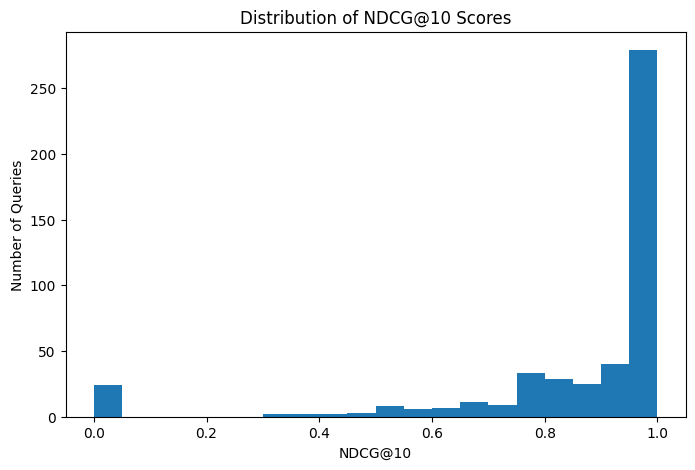

In [21]:
# Task 5c: Analyze the distribution

# YOUR CODE HERE
ndcg_scores = results_df['ndcg']

plt.figure(figsize = (8, 5))
plt.hist(ndcg_scores, bins = 20)
plt.xlabel('NDCG@10')
plt.ylabel('Number of Queries')
plt.title('Distribution of NDCG@10 Scores')
plt.show()

---

## Task 6: Improve Search with Additional Fields

Our baseline only searches the `product_name` field. Let's improve by adding more fields!

### 6a. Index product_class field

The `product_class` field contains the category of the product (e.g., "Rugs", "Coffee Tables"). This is a powerful signal!

Create a search function that combines all three fields (name, description, class).

In [30]:
# Task 6a: Index product_class field

# YOUR CODE HERE
def search_func3(query: str, df: pd.DataFrame = df_product, invert_index_func: Callable = build_index, score_func: Callable = score_bm25, tokenizer: Callable = snowball_tokenize) -> pd.DataFrame:
    
    index_name, doc_lengths_name = invert_index_func(df['product_name'].tolist(), tokenizer)
    index_descp, doc_lengths_descp = invert_index_func(df['product_description'].tolist(), tokenizer)
    index_class, doc_lengths_class = invert_index_func(df['product_class'].tolist(), tokenizer)

    scores_name = score_func(query, index_name, len(df), doc_lengths_name, tokenizer)
    scores_descp = score_func(query, index_descp, len(df), doc_lengths_descp, tokenizer)
    scores_class = score_func(query, index_class, len(df), doc_lengths_class, tokenizer)

    scores = scores_name + scores_descp + scores_class

    idx = np.argsort(-scores)
    results = df.iloc[idx].copy()
    results['score'] = scores[idx]
    results['rank'] = np.arange(1, len(results) + 1)

    return results

### 6b. Evaluate three-field search

Now evaluate your three-field search on all queries to see how it compares to the baseline.

In [31]:
# Task 6b: Evaluate three-field search

# YOUR CODE HERE
results_df3 = evaluate_search(search_func3, df_product, df_query, df_label)

Evaluated 480 queries
Mean NDCG@10: 0.8791


The mean of NDCG@10 for three-field search is 0.8791, which is slightly better than that of the product name search--0.8660.

### 6c. Compare to baseline

Analyze which queries improved and which degraded when using three-field search.

In [40]:
# Task 6c: Compare to baseline

# YOUR CODE HERE
df_compare = results_df.merge(
    results_df3,
    on = ['query_id', 'query'],
    suffixes = ('_baseline', '_three_field')
)

df_compare['ndcg_diff'] = df_compare['ndcg_three_field'] - df_compare['ndcg_baseline']

improve_count = (df_compare['ndcg_diff'] > 0).sum()
degrade_count = (df_compare['ndcg_diff'] < 0).sum()
unchange_count = (df_compare['ndcg_diff'] == 0).sum()

print(f'The number of improved queries: {improve_count}')
print(f'The number of degraded queries: {degrade_count}')
print(f'The number of unchanged queries: {unchange_count}')

biggest_improve_query = df_compare.sort_values('ndcg_diff', ascending = False).head(5)
biggest_degrade_query = df_compare.sort_values('ndcg_diff', ascending = False).tail(5)

print('\nBiggest improved queries are:\n')
for query in biggest_improve_query['query']:
    print(query)

print('\nBiggest degraded queries are:\n')
for query in biggest_degrade_query['query']:
    print(query)

The number of improved queries: 177
The number of degraded queries: 158
The number of unchanged queries: 145

Biggest improved queries are:

bathroom vanity knobs
oriental vanity
family lamp
non slip shower floor tile
medium size chandelier

Biggest degraded queries are:

day bed indian
teal chair
drum picture
70s inspired furniture
midcentury tv unit


The three-field search engine improves matching for semantic searches, but adds nosie for short, styly-based searches.

---

## Task 7: Query Understanding with LLM

Sometimes users search for "star wars rug" when they really want a "rug with Star Wars theme". An LLM can help us understand what the user is actually looking for!

### 7a. Extract product type from query

Write a function using LiteLLM with structured outputs (Pydantic) to extract key information from a query.

In [42]:
# Task 7a: Extract product type, theme, material, color, and any other information you deem relevcant from the query

# YOUR CODE HERE
class product_info(BaseModel):
    product_type: Optional[str] = Field(default = None, description = 'The product type')
    theme: Optional[str] = Field(default = None, description = 'The product theme')
    material: Optional[str] = Field(default = None, description = 'The product material')
    color: Optional[str] = Field(default = None, description = 'The product color')
    location: Optional[str] = Field(default = None, description = 'The product usage location')

def extract_product_info(query: str) -> product_info:
    response = litellm.completion(
        model = 'gpt-5-mini',
        messages = [{
                'role': 'system',
                'content': 'Extract structured information from users\' searching queries.'
            },
            {
                'role': 'user',
                'content': f'Extract information from this query:\n{query}'
            }],
            response_format = product_info
    )

    response_prod = product_info.model_validate_json(response.choices[0].message.content)

    return response_prod

In [47]:
# Test your query understanding function by running it against these test queries
test_queries = [
    "star wars rug",
    "wooden coffee table",
    "blue leather sofa",
    "modern metal bookshelf"
]

for q in test_queries:
    # YOUR CODE HERE
    response_prod = extract_product_info(q)
    print(f'For query: {q}, key information is:\n\n{response_prod.model_dump_json(indent=2)}\n')

For query: star wars rug, key information is:

{
  "product_type": "rug",
  "theme": "Star Wars",
  "material": null,
  "color": null,
  "location": null
}

For query: wooden coffee table, key information is:

{
  "product_type": "coffee table",
  "theme": null,
  "material": "wood",
  "color": null,
  "location": null
}

For query: blue leather sofa, key information is:

{
  "product_type": "sofa",
  "theme": null,
  "material": "leather",
  "color": "blue",
  "location": null
}

For query: modern metal bookshelf, key information is:

{
  "product_type": "bookshelf",
  "theme": "modern",
  "material": "metal",
  "color": null,
  "location": null
}



### 7b. Create an LLM-enhanced search

Use the extracted product type to boost matching results. If the LLM identifies "rug" as the product type, boost products where `product_class` contains "rug".

In [65]:
# Task 7b: Create an LLM-enhanced search

# YOUR CODE HERE
def search_func_llm(query: str, df: pd.DataFrame = df_product, invert_index_func: Callable = build_index, score_func: Callable = score_bm25, tokenizer: Callable = snowball_tokenize, extractor: Callable = extract_product_info) -> pd.DataFrame:
    index_name, doc_lengths_name = invert_index_func(df['product_name'].tolist(), tokenizer)
    index_descp, doc_lengths_descp = invert_index_func(df['product_description'].tolist(), tokenizer)
    index_class, doc_lengths_class = invert_index_func(df['product_class'].tolist(), tokenizer)

    scores_name = score_func(query, index_name, len(df), doc_lengths_name, tokenizer)
    scores_descp = score_func(query, index_descp, len(df), doc_lengths_descp, tokenizer)
    scores_class = score_func(query, index_class, len(df), doc_lengths_class, tokenizer)

    prod_type = (extractor(query).product_type or '').strip().lower()
    for idx, row in df.iterrows():
        if prod_type in str(row['product_class']).lower():
            scores_class[idx] *= 1.25

    llm_score = scores_name + scores_descp + scores_class
    
    idx = np.argsort(-llm_score)
    results = df.iloc[idx].copy()
    results['score'] = llm_score[idx]
    results['rank'] = np.arange(1, len(results) + 1)

    return results

In [66]:
# YOUR CODE HERE
results_df_llm = evaluate_search(search_func_llm, df_product, df_query, df_label)

Evaluated 480 queries
Mean NDCG@10: 0.8801


---
## Task 8: Submit via Pull Request

Now let's submit your work using the Git workflow from previous homeworks.
- [ ] Create a new branch called `homework-3`
- [ ] Commit you work and push it to the branch
- [ ] Create a PR with a nice description of your changes
- [ ] Merge the PR to your main branch
  
**The TA will verify your submission by checking the merged PR on your GitHub repo.**

**Also remember to submit your homework on Blackboard!**
